# Apple Stock Price Analysis

In this notebook, we will use the apple stock price dataset from 2014-2023 (in USD) for time series analysis and forecasting. 

We will try to answer the following questions:
1. What is the change in price of the stock over time?
2. What is apple stock's moving average?
3. How can we predict the closing price of APPLE Inc.?
4. Over the next 30 days (January 2024), what are the closing prices and what will the
volatility look like? 

First, some definitions:

**Open:** This is the price at which the stock first starts trading at during a trading session. It represents the initial valuation of the stock on that day.

**Close:** This is the price at which the stock finishes trading at wehn the trading session ends. It's considered the most crucial price point as it reflects the final sentiment towards the stock for that day.

**High:** This is the highest price the stock reaches during the trading session. It shows the peak demand for the stock throughout the day.

**Low:** This is the lowest price the stock reaches during the trading session. It highlights the weakest point of demand and potential selling pressure.

**Volume:** This represents the total number of shares of the stock that are traded during the session. It indicates the level of buying and selling activity for the stock.

**Adj Close (Adjusted Close):** This is the closing price adjusted for any corporate actions (e.g. stock splits or dividends). It allows for accurate comparison of prices over time by removing the distorting effects of such events.

In [32]:
# necessary libraries 
import itertools
import numpy as np
import statsmodels
import pandas as pd
import seaborn as sns
import tensorflow as tf 
from arch import arch_model
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from matplotlib.dates import DateFormatter
from keras.layers import LSTM, Dense, Input
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Exploratory Data Analysis

In [33]:
df = pd.read_csv('apple_stock.csv')

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,258529600


In [35]:
df.shape

(2475, 7)

In [36]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2.475000e+03
mean,76.004968,76.845661,75.213720,76.064199,74.097124,1.380565e+08
std,54.739063,55.389713,54.134658,54.787600,55.248195,8.399674e+07
min,17.684999,17.911785,17.626785,17.849285,15.648315,3.145820e+07
25%,29.592500,29.841249,29.371249,29.707500,27.131330,8.300500e+07
50%,47.507500,47.967499,47.267502,47.599998,45.507229,1.134760e+08
75%,132.145004,133.680000,130.495003,132.029999,130.403320,1.682138e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2475 non-null   object 
 1   Open       2475 non-null   float64
 2   High       2475 non-null   float64
 3   Low        2475 non-null   float64
 4   Close      2475 non-null   float64
 5   Adj Close  2475 non-null   float64
 6   Volume     2475 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 135.5+ KB


In [38]:
# check for duplicates
duplicate_dates = df[df.duplicated(subset='Date')]
print("Duplicate Dates:")
print(duplicate_dates)

# check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Duplicate Dates:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []

Missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [39]:
# converting 'Date' to a datetime format and setting as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Check for Stationarity

In [40]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

# check stationarity of the 'Close' price
check_stationarity(df['Close'])

ADF Statistic: -0.15617128346699702
p-value: 0.9435482135857374
Critical Value (1%): -3.43301536964955
Critical Value (5%): -2.862717536880851
Critical Value (10%): -2.5673968500527855


The results from the ADF test indicate that the series is not stationary considering the p-value is greater than 0.05. As a result, we must apply differencing to make the series stationary in order to use the ARIMA model.

Before making the data stationary, we will plot the trend and volume of the stock prices for better understanding.

## 1. What is the change in price of the stock over time?

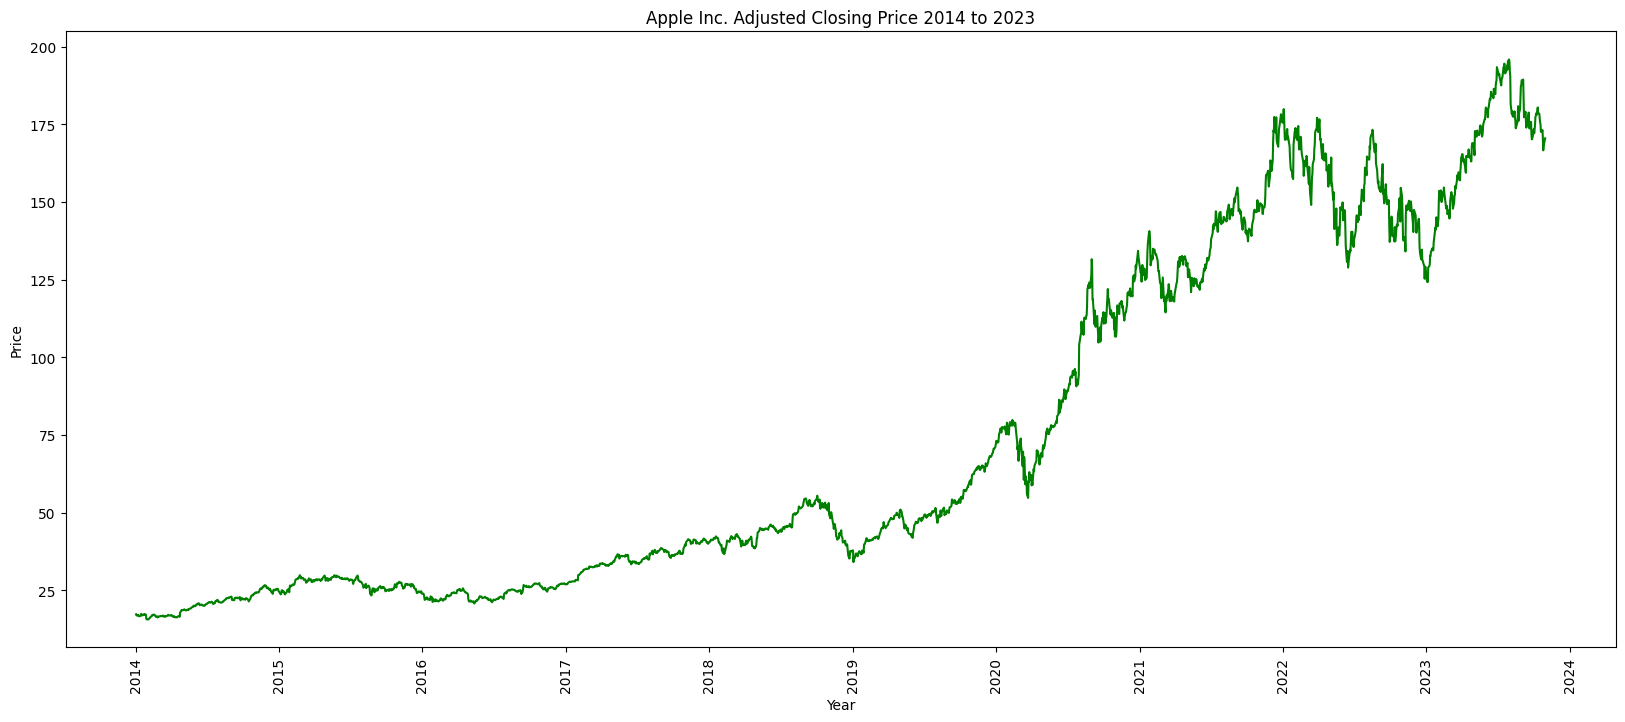

In [41]:
# plot the histrorical view of the adjusted closing price
plt.figure(figsize=(20, 8))
plt.plot(df['Adj Close'], color = 'green')
plt.title('Apple Inc. Adjusted Closing Price 2014 to 2023')
plt.ylabel('Price')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 0, 'Year')

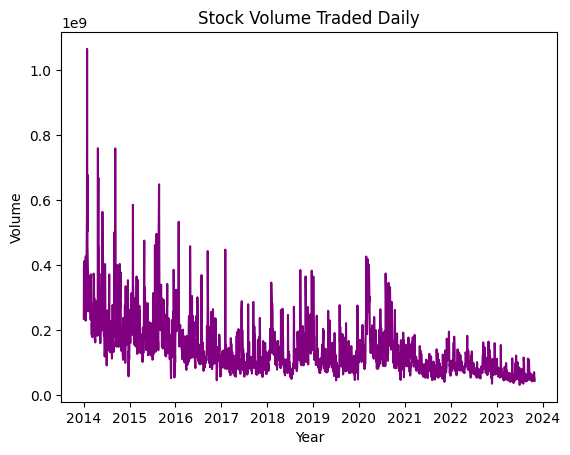

In [42]:
# plot the total volume of stock traded each day
plt.plot(df['Volume'], color = 'purple')
plt.title('Stock Volume Traded Daily')
plt.ylabel('Volume')
plt.xlabel('Year')

After visualizing adjusted closing price and volume over time, we can begin to investigate the moving average. 

## 2. What is apple stock's moving average?

We calculate the moving average for 10, 20, and 50-day periods.

In [43]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] =  df['Adj Close'].rolling(ma).mean()

print(df.columns)    

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA for 10 days',
       'MA for 20 days', 'MA for 50 days'],
      dtype='object')


We now plot all the moving averages.

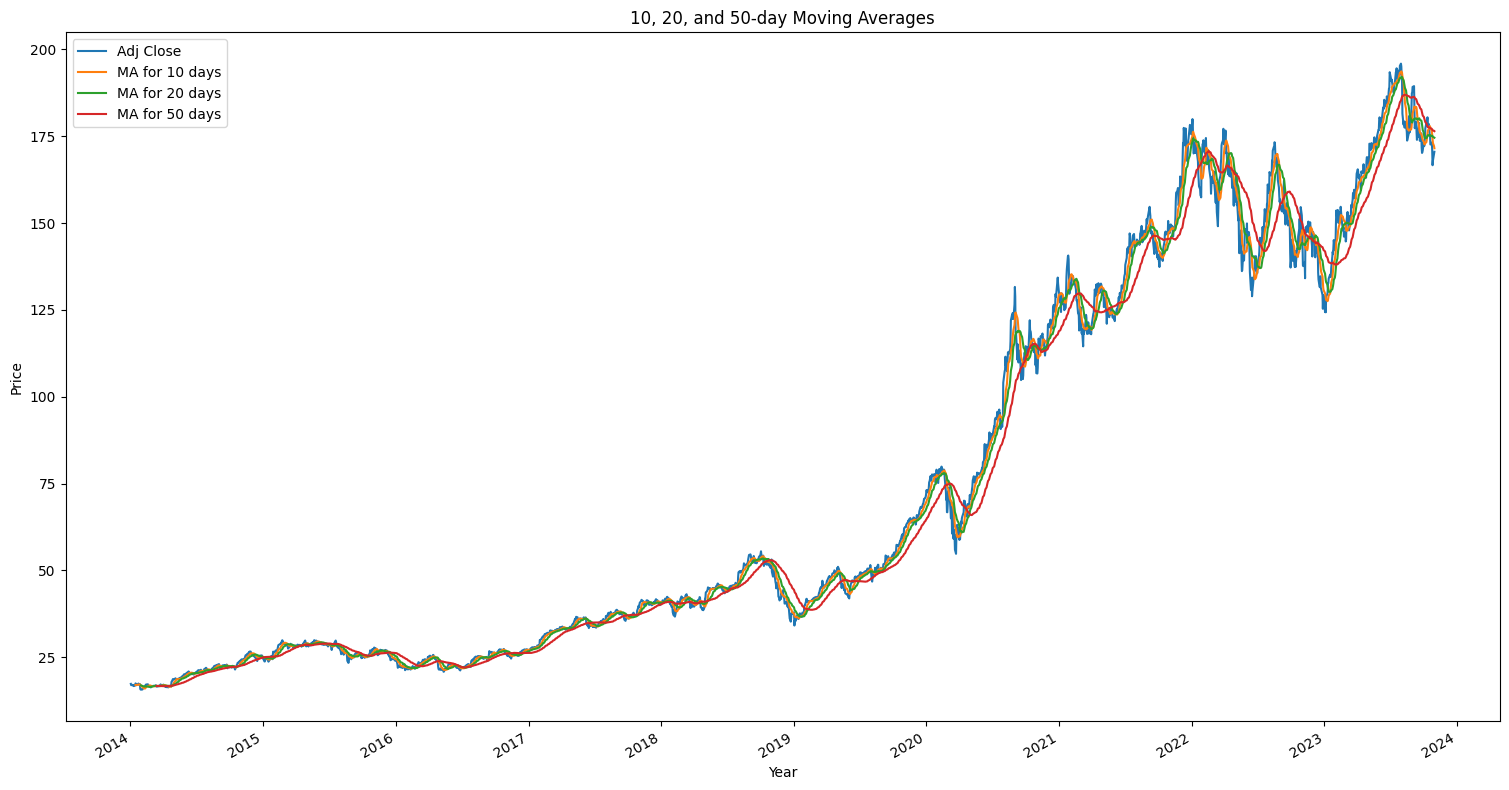

In [44]:
fig, axes = plt.subplots(figsize=(15, 8))  
 
df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes)
axes.set_title('10, 20, and 50-day Moving Averages')
fig.tight_layout()
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

## 3. How can we predict the closing price of APPLE Inc.?

In [45]:
np.random.seed(123)

# create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [46]:
# create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.01066825, 0.00823866, 0.00882855, 0.00805069, 0.00873458,
       0.0073468 , 0.00663091, 0.00718883, 0.00932048, 0.01151411,
       0.01089222, 0.00817666, 0.00985639, 0.01034431, 0.01127815,
       0.00925649, 0.01014233, 0.00134379, 0.00019397, 0.        ,
       0.00016397, 0.00034994, 0.0018017 , 0.00256158, 0.00254558,
       0.00397935, 0.00584105, 0.00723482, 0.00722681, 0.00892855,
       0.00884055, 0.00924049, 0.00751677, 0.00627297, 0.00509317,
       0.00555309, 0.00445528, 0.00351343, 0.00557709, 0.00529114,
       0.00559509, 0.00629097, 0.00651494, 0.00619298, 0.006131  ,
       0.00622699, 0.00726081, 0.00736479, 0.00617299, 0.00498119,
       0.00539112, 0.00632296, 0.00629497, 0.00578306, 0.00661691,
       0.00788071, 0.00904052, 0.00799869, 0.00753477, 0.00741478])]
[0.007390796983410969]

[array([0.01066825, 0.00823866, 0.00882855, 0.00805069, 0.00873458,
       0.0073468 , 0.00663091, 0.00718883, 0.00932048, 0.01151411,
       0.01089222, 0.00817666, 0.0

(1920, 60, 1)

#### Building the LSTM Model

In [47]:
# define the input shape
input_shape = (x_train.shape[1], 1)

# C=create the model
model = Sequential()

# use Input layer to define input shape
model.add(Input(shape=input_shape))

# add LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))

# add dense layers
model.add(Dense(25))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=5)

# print the model summary
print(model.summary())

# print the training history
print(history.history)

Epoch 1/5
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 0.0022
Epoch 2/5
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - loss: 5.0999e-04
Epoch 3/5
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - loss: 2.7109e-04
Epoch 4/5
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - loss: 2.5064e-04
Epoch 5/5
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 2.0697e-04


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

None
{'loss': [0.0008740939083509147, 0.00043812242802232504, 0.0002714215370360762, 0.00022962476941756904, 0.0002365727414144203]}


In [48]:
# create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]

# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# convert the data to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# get the predicted values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [49]:
# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

3.1532130644683996


In [50]:
# calculate absolute percentage errors
percentage_errors = np.abs((predictions - y_test) / y_test) * 100

# calculate MAPE
mape = np.mean(percentage_errors)
print(mape)

1.5606731771108577


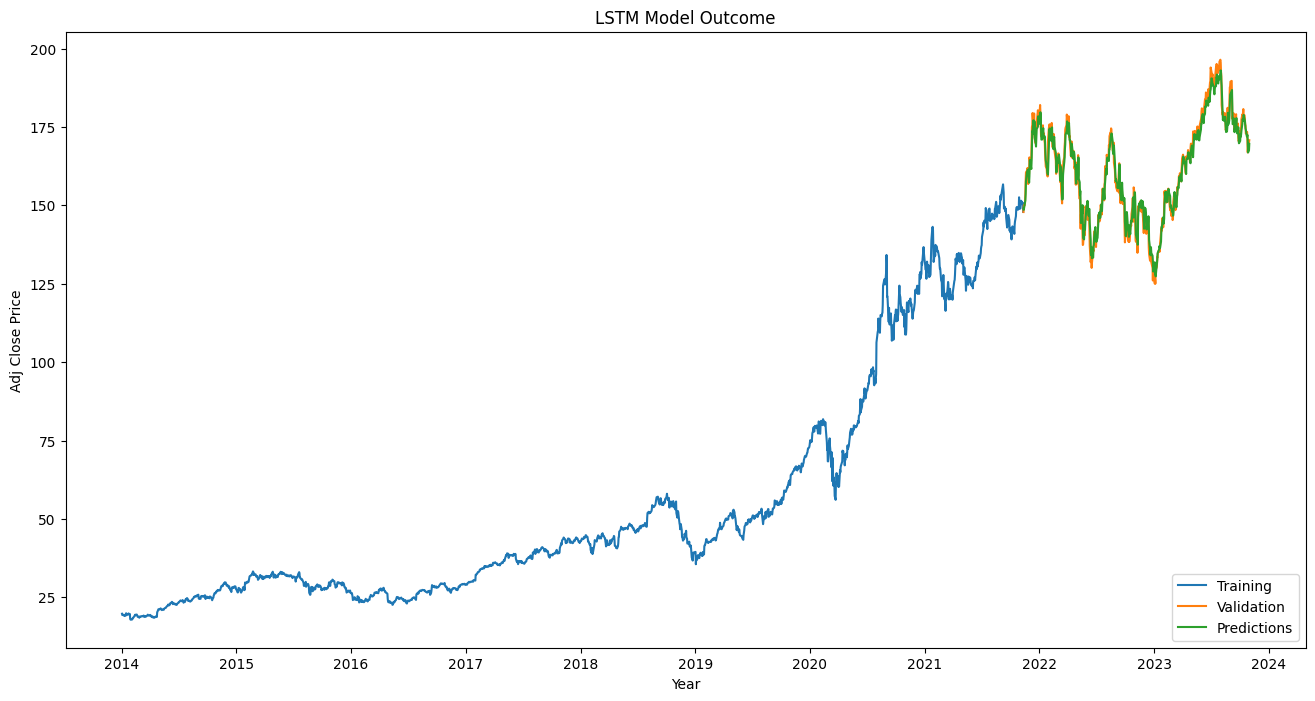

In [51]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.assign(Predictions=predictions)

# visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM Model Outcome')
plt.xlabel('Year')
plt.ylabel('Adj Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [52]:
# valid vs. predicted prices
print(valid)

                 Close  Predictions
Date                               
2021-11-11  147.869995   149.027710
2021-11-12  149.990005   148.558624
2021-11-15  150.000000   150.337509
2021-11-16  151.000000   150.772217
2021-11-17  153.490005   151.581039
...                ...          ...
2023-10-25  171.100006   172.475571
2023-10-26  166.889999   170.633362
2023-10-27  168.220001   166.858719
2023-10-30  170.289993   167.541763
2023-10-31  170.770004   169.623108

[495 rows x 2 columns]


## 4. Over the next 30 days (January 2024), what are the closing prices and what will the volatility look like?

We can also try to predict the closing prices of the next month(January 2024)

In [53]:
# calculate log returns
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
# remove the first row with NaN return
df.dropna(inplace=True)  

Fit ARIMA Model

In [54]:
# check stationarity of log returns
check_stationarity(df['log_return'])

# setting daily period
df.set_index(df.index,inplace=True)
df.index = df.index.to_period('D')

# fit ARIMA model
arima_model = statsmodels.tsa.arima.model.ARIMA(df['log_return'], order=(1, 0, 0))  # can change the order based on AIC/BIC
arima_result = arima_model.fit()
print(arima_result.summary())

ADF Statistic: -15.375722440665623
p-value: 3.460565435975649e-28
Critical Value (1%): -3.433058423074162
Critical Value (5%): -2.8627365488673258
Critical Value (10%): -2.567406972356031
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2426
Model:                 ARIMA(1, 0, 0)   Log Likelihood                6306.056
Date:                Thu, 13 Jun 2024   AIC                         -12606.112
Time:                        15:18:00   BIC                         -12588.730
Sample:                    03-14-2014   HQIC                        -12599.792
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009 

Fit GARCH Model

In [55]:
# fit GARCH model on ARIMA residuals
rescaled_residuals = arima_result.resid * 100
garch_model = arch_model(rescaled_residuals, vol='Garch', p=1, q=2)
garch_result = garch_model.fit(disp="off")
print(garch_result.summary())

# forecast volatility for January 2024
forecast_steps = 23 # some days in january missing (this forecasts through jan 31st)
garch_forecast = garch_result.forecast(horizon=forecast_steps)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4628.76
Distribution:                  Normal   AIC:                           9267.52
Method:            Maximum Likelihood   BIC:                           9296.49
                                        No. Observations:                 2426
Date:                Thu, Jun 13 2024   Df Residuals:                     2425
Time:                        15:18:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0782  3.394e-02      2.303  2.127e-02 [1.165e-0

Combine Forecasts and Visualize

Optimize ARIMA Model Parameters

In [56]:
# define a function to find the best ARIMA parameters using cross-validation
def find_best_arima_params(time_series, pdq_range):
    tscv = TimeSeriesSplit(n_splits=5)
    best_aic = float('inf')
    best_params = None

    for param in pdq_range:
        aic_values = []
        for train_index, val_index in tscv.split(time_series):
            train, val = time_series[train_index], time_series[val_index]
            try:
                model = ARIMA(train, order=param)
                result = model.fit()
                aic_values.append(result.aic)
            except:
                continue
        avg_aic = np.mean(aic_values)
        if avg_aic < best_aic:
            best_aic = avg_aic
            best_params = param

    return best_params, best_aic

# range for p, d, q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_pdq_aic, best_aic = find_best_arima_params(df['log_return'].values, pdq)
print(f'Best ARIMA parameters by AIC: {best_pdq_aic} with AIC: {best_aic}')

# fit the best ARIMA model
best_arima_model = ARIMA(df['log_return'], order=best_pdq_aic)
best_arima_result = best_arima_model.fit()

c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting p

Best ARIMA parameters by AIC: (1, 0, 0) with AIC: -6505.880620922171


In [57]:
# define the range for p, d, q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# initialize variables to store the best results
best_aic = float('inf')
best_bic = float('inf')
best_pdq_aic = None
best_pdq_bic = None

# grid search over the p, d, q combinations
for param in pdq:
    try:
        arima_model = ARIMA(df['log_return'], order=param)
        arima_result = arima_model.fit()
        
        # compare AIC and BIC
        if arima_result.aic < best_aic:
            best_aic = arima_result.aic
            best_pdq_aic = param
            
        if arima_result.bic < best_bic:
            best_bic = arima_result.bic
            best_pdq_bic = param
    except Exception as e:
        continue

print(f'Best ARIMA parameters by AIC: {best_pdq_aic} with AIC: {best_aic}')
print(f'Best ARIMA parameters by BIC: {best_pdq_bic} with BIC: {best_bic}')

# fit the best ARIMA model based on AIC
best_arima_model = ARIMA(df['log_return'], order=best_pdq_aic)
best_arima_result = best_arima_model.fit()
print(best_arima_result.summary())

c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mecheste\Downloads\time series final project\.conda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting p

Best ARIMA parameters by AIC: (2, 0, 2) with AIC: -12608.58528951403
Best ARIMA parameters by BIC: (0, 0, 1) with BIC: -12588.872109517852
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2426
Model:                 ARIMA(2, 0, 2)   Log Likelihood                6310.293
Date:                Thu, 13 Jun 2024   AIC                         -12608.585
Time:                        15:19:53   BIC                         -12573.821
Sample:                    03-14-2014   HQIC                        -12595.945
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.612      0.009       0.000     

Check Residuals of the ARIMA Model

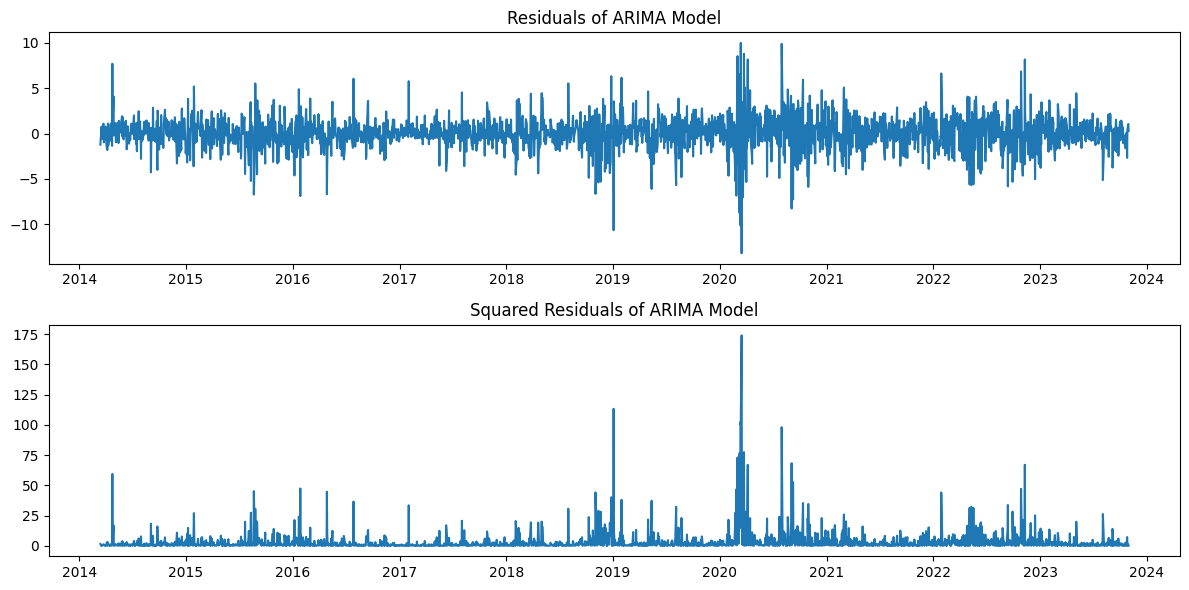

      lb_stat  lb_pvalue
10  42.430607   0.000006


In [58]:
# plot residuals
residuals = best_arima_result.resid * 100
timestamps = df.index.to_timestamp()

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(timestamps, residuals)
plt.title('Residuals of ARIMA Model')

plt.subplot(212)
plt.plot(timestamps, residuals**2)
plt.title('Squared Residuals of ARIMA Model')
plt.tight_layout()
plt.show()

# perform Ljung-Box test for autocorrelation in residuals
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

Optimize GARCH Model

In [59]:
# define the range for p, q
p = range(1, 4)
q = range(1, 4)

# initialize variables to store the best results
best_aic_garch = float('inf')
best_bic_garch = float('inf')
best_pq_aic = None
best_pq_bic = None

# grid search over the p, q combinations
for param in itertools.product(p, q):
    try:
        garch_model = arch_model(best_arima_result.resid * 100, vol='Garch', p=param[0], q=param[1])
        garch_result = garch_model.fit(disp="off")
        
        # compare AIC and BIC
        if garch_result.aic < best_aic_garch:
            best_aic_garch = garch_result.aic
            best_pq_aic = param
            
        if garch_result.bic < best_bic_garch:
            best_bic_garch = garch_result.bic
            best_pq_bic = param
    except Exception as e:
        continue

print(f'Best GARCH parameters by AIC: {best_pq_aic} with AIC: {best_aic_garch}')
print(f'Best GARCH parameters by BIC: {best_pq_bic} with BIC: {best_bic_garch}')

# fit the best GARCH model based on AIC
best_garch_model = arch_model(best_arima_result.resid * 100, vol='Garch', p=best_pq_aic[0], q=best_pq_aic[1])
best_garch_result = best_garch_model.fit(disp="off")
print(best_garch_result.summary())

Best GARCH parameters by AIC: (1, 1) with AIC: 9264.499382294693
Best GARCH parameters by BIC: (1, 1) with BIC: 9287.675378652708
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4628.25
Distribution:                  Normal   AIC:                           9264.50
Method:            Maximum Likelihood   BIC:                           9287.68
                                        No. Observations:                 2426
Date:                Thu, Jun 13 2024   Df Residuals:                     2425
Time:                        15:19:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------

Re-evaluate and Forecast

            Forecast_Return  Forecast_Volatility
Date                                            
2024-01-01         0.000680             0.013904
2024-01-02         0.000573             0.014126
2024-01-03         0.001064             0.014334
2024-01-04         0.000711             0.014529
2024-01-05         0.001070             0.014712
2024-01-08         0.000742             0.014884
2024-01-09         0.001051             0.015046
2024-01-10         0.000762             0.015198
2024-01-11         0.001033             0.015342
2024-01-12         0.000780             0.015477
2024-01-15         0.001017             0.015604
2024-01-16         0.000795             0.015724
2024-01-17         0.001002             0.015837
2024-01-18         0.000808             0.015944
2024-01-19         0.000990             0.016046
2024-01-22         0.000820             0.016141
2024-01-23         0.000979             0.016231
2024-01-24         0.000830             0.016317
2024-01-25         0

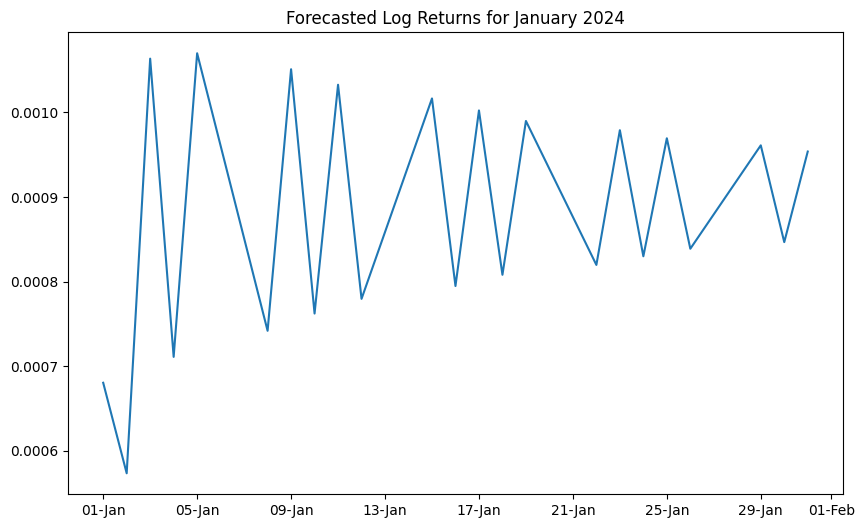

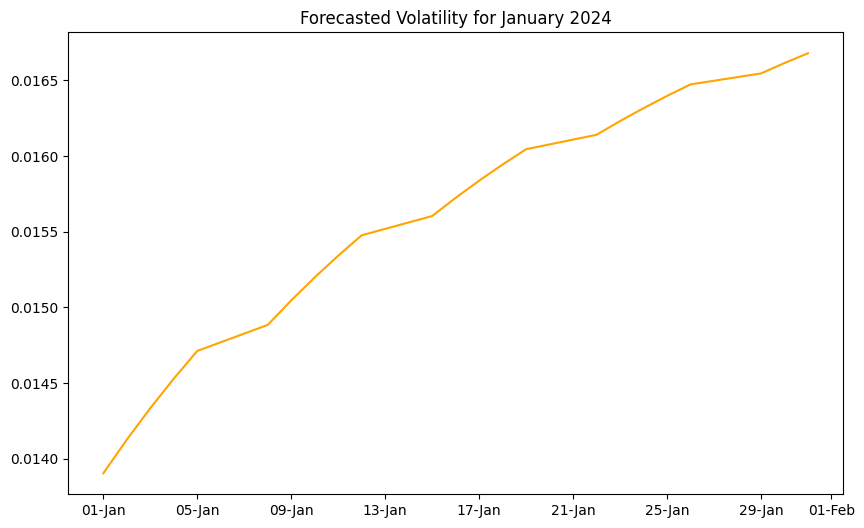

In [60]:
# forecast returns for january 2024 
forecast_steps = 23 # ends up being all of january, some data missing
arima_forecast = best_arima_result.get_forecast(steps=forecast_steps)
forecast_mean = arima_forecast.predicted_mean
forecast_ci = arima_forecast.conf_int()

# forecast volatility for january 2024
garch_forecast = best_garch_result.forecast(horizon=forecast_steps)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])/100

# generate date range for the forecast period
forecast_dates = pd.bdate_range(start='2024-01-01', periods=forecast_steps)

# combine return and volatility forecasts
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast_Return': forecast_mean,
    'Forecast_Volatility': forecast_volatility
})

forecast_df.set_index('Date', inplace=True)
print(forecast_df)

# plot forecasted returns
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['Forecast_Return'], label='Forecasted Returns')
plt.title('Forecasted Log Returns for January 2024')

# Format x-axis to show only day
date_form = DateFormatter("%d-%b")
plt.gca().xaxis.set_major_formatter(date_form)

plt.show()

# plot forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['Forecast_Volatility'], label='Forecasted Volatility', color='orange')
plt.title('Forecasted Volatility for January 2024')

# Format x-axis to show only day
date_form = DateFormatter("%d-%b")
plt.gca().xaxis.set_major_formatter(date_form)

plt.show()

Convert Log Returns to Prices

In [61]:
# get the last known closing price
last_known_price = df['Close'].iloc[-1]

# initialize a list to store the forecasted prices
forecast_prices = [last_known_price]

# convert forecasted log returns to forecasted prices
for return_value in forecast_df['Forecast_Return']:
    new_price = forecast_prices[-1] * np.exp(return_value)
    forecast_prices.append(new_price)

# remove the last known price to match the forecast period
forecast_prices = forecast_prices[1:]

# add the forecasted prices to the dataframe
forecast_df['Forecast_Price'] = forecast_prices

print(forecast_df)

            Forecast_Return  Forecast_Volatility  Forecast_Price
Date                                                            
2024-01-01         0.000680             0.013904      170.886222
2024-01-02         0.000573             0.014126      170.984215
2024-01-03         0.001064             0.014334      171.166181
2024-01-04         0.000711             0.014529      171.287912
2024-01-05         0.001070             0.014712      171.471290
2024-01-08         0.000742             0.014884      171.598535
2024-01-09         0.001051             0.015046      171.779004
2024-01-10         0.000762             0.015198      171.909984
2024-01-11         0.001033             0.015342      172.087623
2024-01-12         0.000780             0.015477      172.221830
2024-01-15         0.001017             0.015604      172.396999
2024-01-16         0.000795             0.015724      172.534065
2024-01-17         0.001002             0.015837      172.707099
2024-01-18         0.0008

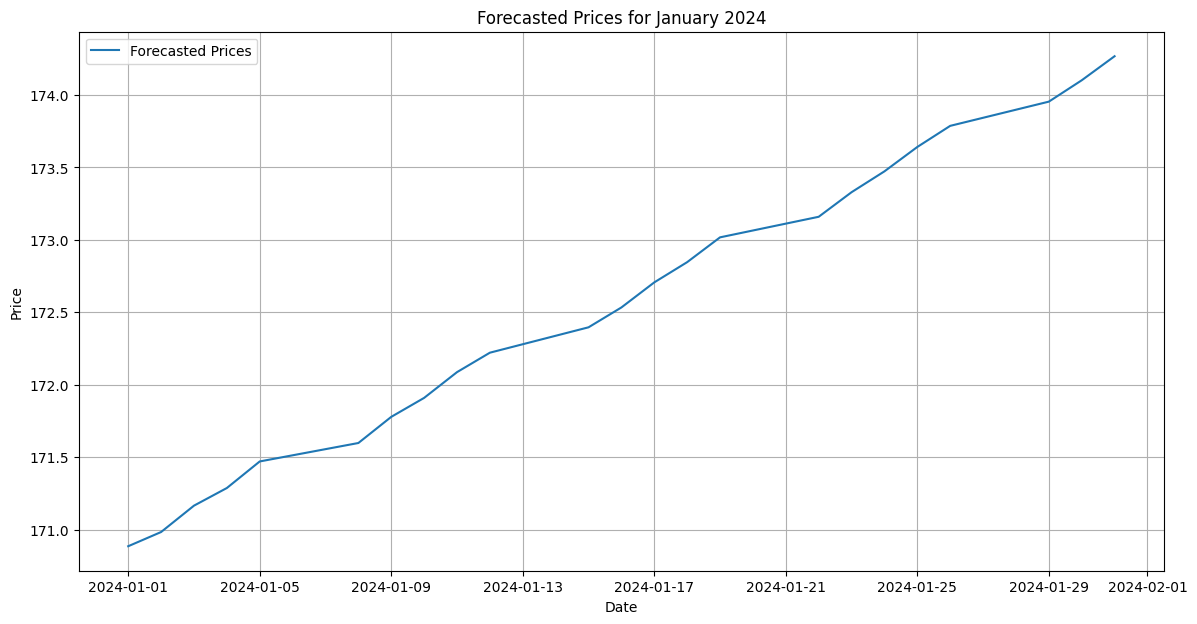

In [62]:
plt.figure(figsize=(14, 7))

# plot forecasted prices
plt.plot(forecast_df['Forecast_Price'], label='Forecasted Prices')
plt.title('Forecasted Prices for January 2024')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Explanation of Model Underperformance

#### Model Assumptions and Limitations:

**ARIMA Assumptions:**
- **Linear Relationships:** ARIMA models assume linear relationships between variables. Stock prices, however, often exhibit non-linear patterns influenced by market sentiment, news events, and investor behavior.
- **Stationarity:** ARIMA requires the time series to be stationary, meaning its statistical properties do not change over time. Stock prices typically display trends and seasonalities, challenging the stationarity assumption.

**GARCH Assumptions:**
- **Conditional Heteroskedasticity:** GARCH models assume that volatility clusters and varies over time according to a specific pattern. This assumption might not capture sudden changes in volatility due to unexpected events or market shocks.
- **Model Structure:** The structure of GARCH models might oversimplify the complexities of stock price volatility, leading to underestimation or overestimation in volatile periods.

#### Data Limitations:

**Historical Data:**
- **Time Horizon:** Models trained on historical data up to December 2023 might not fully account for recent market conditions or upcoming events in January 2024.
- **Outliers and Shocks:** Market shocks, regulatory changes, or company-specific announcements can introduce outliers that significantly influence stock prices but are not adequately captured by historical data.

#### Parameter Estimation:

**Model Complexity and Fit:**
- **Overfitting/Underfitting:** Models with too many parameters can overfit to historical data, capturing noise rather than genuine patterns. Conversely, simpler models may underfit and fail to capture all relevant dynamics.
- **Parameter Selection:** The chosen ARIMA and GARCH parameters might not generalize well to new data, impacting the accuracy of forecasts.

#### External Factors:

**Market Efficiency:**
- **Efficient Market Hypothesis (EMH):** According to EMH, stock prices reflect all available information, making it challenging to predict future prices accurately using historical data alone. Unforeseen information or events can swiftly impact stock prices, beyond the scope of historical models.